## Pontificia Universidad Javeriana

*Autores:*
- Diego Alejandro Jara Rojas  
- Juan Felipe Gonz√°lez Quintero  
- Tom√°s Felipe Guerra Hern√°ndez  
- Isa√≠as Acosta Herrera  

*Fecha de Inicio:* 10 - 10 - 2025  
*Fecha de Finalizaci√≥n:* 17 - 10 - 2025  

---

## **Proyecto**
*An√°lisis de los factores socioecon√≥micos y delictivos asociados a los arrestos en la ciudad de Nueva York mediante t√©cnicas de procesamiento de Big Data.*

---

## **Problem√°tica**
El aumento de arrestos en ciertos distritos de Nueva York plantea la necesidad de analizar qu√© factores pueden estar influyendo en esta tendencia.  
Mediante la integraci√≥n de datos sobre pobreza, criminalidad en escuelas y registros de arrestos, se busca identificar patrones y correlaciones que permitan entender si la desigualdad socioecon√≥mica y la violencia escolar tienen un impacto significativo en las tasas de arrestos.

---

## **Objetivo**
Realizar un an√°lisis exploratorio y predictivo sobre los arrestos en Nueva York a partir de datos p√∫blicos de pobreza, cr√≠menes en escuelas y reportes policiales, con el fin de determinar posibles relaciones entre las condiciones sociales y los niveles de criminalidad y detenci√≥n.

---

## **Metodolog√≠a**

1. *Importaci√≥n de datos desde el cluster*  
   Carga de datasets en distintos formatos (CSV, Parquet) provenientes de fuentes oficiales del estado de Nueva York.  

2. *Preprocesamiento y limpieza de datos*  
   Estandarizaci√≥n de valores, manejo de nulos, combinaci√≥n de bases de datos y normalizaci√≥n de variables.  

3. *An√°lisis exploratorio de datos (EDA)*  
   C√°lculo de medidas estad√≠sticas y visualizaci√≥n de distribuciones para identificar tendencias por distrito, tipo de crimen, nivel de pobreza y n√∫mero de arrestos.  

4. *Modelado y correlaci√≥n de variables*  
   Aplicaci√≥n de modelos estad√≠sticos y de aprendizaje autom√°tico (como regresi√≥n lineal y modelos de correlaci√≥n m√∫ltiple) para evaluar relaciones entre pobreza, crimen y arrestos.  

5. *Evaluaci√≥n e interpretaci√≥n*  
   An√°lisis de resultados y visualizaci√≥n de patrones espaciales y sociales relevantes para comprender los factores m√°s influyentes en la tasa de arrestos. (Ver documento)

6. *Fuentes de referencia*  
   - Open Data NYC  
   - Department of Education NYC  
   - NYPD Arrest Data Reports  
   - Art√≠culos y estudios previos sobre desigualdad y criminalidad¬†urbana.

# **1.Importaci√≥n y configuraci√≥n de recursos**

In [1]:
#Verificamos que estemos usando la versi√≥n de python instalada en nuestro cluster mediante conda
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
#Importaci√≥n de todas las bibliotecas necesarias para procesamiento, gr√°ficas y otros recursos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bibliotecas especializadas
from pylab import *

In [3]:
import os

# Ajuste de las variables de entorno
os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
# Bibliotecas de Contexto PySpark, MLlib y contexto para levantar la sesi√≥n de PYSPARK

#B√∫squeda de inicializaci√≥n para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Se crea una sesi√≥n para hacer el contexto de procesamiento desde mi Cuota de cluster HPC (No tenemos acceso a todos los cores, son compartidos)
from pyspark import SparkConf
##Se levanta la configuraci√≥n de mi Cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

configura.setAppName("NY_Arrestos_Proyecto")

sparkSPA = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext = sparkSPA.sparkContext, sparkSession = sparkSPA)

contextoSparkSPA = sparkSPA.sparkContext.getOrCreate()

print("Sesi√≥n cluster Arrestos")

sparkSPA

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 23:14:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/21 23:14:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesi√≥n cluster Arrestos


In [6]:
# Como estoy desde un servidor que no es m√≠o y ni siquiera lo he implementado
# Requiero saber que configuraci√≥n de hardware le han dado a mi cuota de sesi√≥n
# Adicional, requiero como hacer un cluster para saber la forma en la que se implementa

cantCPUS = sparkSPA._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPUS en mi cuota de sesi√≥n sparkSPA: {cantCPUS} ")
print(sparkSPA.sparkContext.getConf().getAll())

Cantidad de CPUS en mi cuota de sesi√≥n sparkSPA: 1 
[('spark.app.name', 'NY_Arrestos_Proyecto'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.

# **2. Carga de datos desde el cl√∫ster**

In [7]:
#Especificamos la ruta donde est√° ubicado el archivo csv en el cu√°l vamos a basarnos para su procesamiento y an√°lsis.
ruta = "/almacen/proyecto/NYPD_Arrests_Data__Historic__20251009.csv"

#Cargamos el archivo en forma de un dataframe con PySpark y mostramos los primeros 5 registros para verificar la carga correcta del archivo.
df00 = sparkSPA.read.csv(ruta, header=True, inferSchema=True)
df00.show(5)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|  101|           ASSAULT 3|  344|ASSAULT 3 & RELAT...|PL 1200001|         M|          K|             73|                0|    25-44|       M|               BLACK|   1012087

# **3. An√°lisis y Preparaci√≥n de Datos**

Se presentan datos (csv) con los diferentes par√°metros asociados a las detenciones realizadas en la ciudad de Nueva York. En esta secci√≥n se realiza una exploraci√≥n de las variables que componen este conjunto de datos a trav√©s de la descripci√≥n de:

- **Tipo de datos:** coherencia de tipo de datos, transformaci√≥n, etc.
- **Columnas:** conocimiento de columnas, eliminaci√≥n.
- **An√°lisis de datos nulos o imposibles:** conocimiento.

In [8]:
#Conocimiento de las columnas
df00.columns

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'Lon_Lat']

Las columnas m√°s importantes para este estudio son las siguientes:

- **ARREST_KEY:** Llave √∫nica generada aleatoriamente para identificar cada arresto.
- **ARREST_DATE:** Fecha exacta del arresto.
- **LAW_CODE:** Cargos acordes al c√≥digo penal del Estado de Nueva York de los cu√°les se acusa al arrestado.
- **LAW_CAT_CD:** Nivel del delito: delito grave, delito menor o infracci√≥n.
- **ARREST_BORO:** Distrito donde se produjo la detenci√≥n: B (Bronx), S (Staten Island), K (Brooklyn), M (Manhattan), Q (Queens).
- **ARREST_PRECINCT:** Distrito policial donde se realiz√≥ la detenci√≥n.
- **AGE_GROUP:** Categor√≠a de edad del perpetrador.
- **PERP_SEX:** Descripci√≥n del sexo del perpetrador.
- **PERP_RACE:** Descripci√≥n de la raza a la que pertenece el perpetrador.
- **X_COORD_CD:** Coordenada X de mitad de bloque para el sistema de coordenadas del estado de Nueva York, zona de Long Island, NAD 83, unidades en pies (FIPS 3104)
- **Y_COORD_CD:** Coordenada Y de mitad de bloque para el sistema de coordenadas del estado de Nueva York, zona de Long Island, NAD 83, unidades en pies (FIPS 3104)
- **Latitude:** Latitud representada en el Sistema Global de Coordenadas en Grados Decimales.
- **Longitude:** Longitud representada en el Sistema Global de Coordenadas en Grados Decimales.
- **Lon_Lat:** Columna de puntos georreferenciados basada en los campos de longitud y latitud.

In [9]:
#Se procede a identificar los tipos de datos originales del conjunto de datos de Arrestos
df00.dtypes

[('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('PD_CD', 'int'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'int'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'int'),
 ('JURISDICTION_CODE', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Lon_Lat', 'string')]

Como se puede evidenciar, **no existen variables en este conjunto de datos a las que sea necesario aplicarles una transformaci√≥n en primera instancia**, con lo que este paso **ser√° omitido**. Sin embargo, m√°s adelante se realizar√°n procesos de estandarizaci√≥n de algunas variables para que estas coincidan y puedan relacionarse de mejor forma con los otros conjuntos de datos utilizados en este estudio (Pobreza e Incidentes en escuelas de Nueva York).

In [10]:
#Se hace una descripci√≥n estad√≠sitca de los par√°metros/variables del conjunto de datos para una exploraci√≥n inicial
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+--------------------+
|summary|          ARREST_KEY|
+-------+--------------------+
|  count|              246773|
|   mean|1.8273193780121407E8|
| stddev|  5920200.7362956125|
|    min|           173129257|
|    max|           191719213|
+-------+--------------------+



+-------+-----------+
|summary|ARREST_DATE|
+-------+-----------+
|  count|     246773|
|   mean|       NULL|
| stddev|       NULL|
|    min| 01/01/2018|
|    max| 12/31/2018|
+-------+-----------+

+-------+------------------+
|summary|             PD_CD|
+-------+------------------+
|  count|            246704|
|   mean|467.85989282703156|
| stddev| 279.4868938180626|
|    min|                 0|
|    max|               997|
+-------+------------------+



+-------+--------------------+
|summary|             PD_DESC|
+-------+--------------------+
|  count|              245848|
|   mean|                NULL|
| stddev|                NULL|
|    min|A.B.C.,FALSE PROO...|
|    max|WEAPONS,PROHIBITE...|
+-------+--------------------+

+-------+-----------------+
|summary|            KY_CD|
+-------+-----------------+
|  count|           245848|
|   mean|268.2900328658358|
| stddev|151.0865849908115|
|    min|              101|
|    max|              995|
+-------+-----------------+

+-------+--------------------+
|summary|           OFNS_DESC|
+-------+--------------------+
|  count|              245848|
|   mean|                NULL|
| stddev|                NULL|
|    min|            ABORTION|
|    max|VEHICLE AND TRAFF...|
+-------+--------------------+

+-------+----------+
|summary|  LAW_CODE|
+-------+----------+
|  count|    246728|
|   mean|      NULL|
| stddev|      NULL|
|    min|ABC00000MA|
|    max|VTL125100A|
+-------+----------

## **Exploraci√≥n de valores nulos en los datos**

En esta secci√≥n usamos diferentes consultas para **revisar si en el conjunto de datos existen datos nulos o con valores imposibles** para poder realizar su limpieza, ya de no realizarse, podr√≠a verse afectada la generaci√≥n de visualizaciones gr√°ficas y las conclusiones a sacar de este estudio.

In [11]:
#Rastreamos la cantidad de valores nulos o imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

[Stage 60:==============>                                           (1 + 3) / 4]

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+
|         0|          0|   69|    925|  925|      925|      45|      1695|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|      0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+-------+



Con esto se comprueba que **efectivamente existen varias columnas con datos nulos** por lo que para generar un dataframe para realizar las visualizaciones del conjunto de datos, **conservaremos √∫nicamente** los datos sin estos registros (m√°s adelante se eliminar√°n varias de las columnas que tienen datos nulos ya que no poseen informaci√≥n √∫til para el estudio)

# **4. Eliminaci√≥n de columnas no relevantes**


Para este estudio se contempla hacer uso de algunas de las columnas del conjunto de datos de arrestos, por lo que se procede a eliminar aquellas que no representan informaci√≥n importante.

In [12]:
#Eliminamos las columnas que no son relevantes para el estudio
df01 = df00.drop('PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CAT_CD', 'JURISDICTION_CODE')
#Mostramos las primeras 10 filas para verificar que los cambios hayan sido aplicados
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          K|             73|    25-44|       M|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          S|            123|    25-44|       M|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          Q|            102|    25-44|  

Las columnas seleccionadas para continuar con el estudio se justifican a continuaci√≥n:

- **ARREST_KEY y ARREST_DATE:** Permiten identificar cada detenci√≥n realizada a trav√©s de una clave combinada √∫nica.
- **LAW_CODE y LAW_CAT_CD:** Permite identificar con mayor detalle el car√°cter de la ley quebrantada y justificar la detenci√≥n.
- **ARREST_BORO y ARREST_PRECINCT:** Permiten ubicar geogr√°ficamente el arresto y adem√°s, relacionar por medio del distrito la informaci√≥n de este conjunto de datos con la que se presenta en los dem√°s conjuntos utilizados para este estudio.
- **AGE_GROUP, PERP_SEX y PERP_RACE:** Reflejan parte de las caracter√≠sticas clave del perpetrador con mayor detalle. Esto permite construir arquetipos de persona para realizar un mejor an√°lisis sobre los datos.
- **X_COORD_CD, Y_COORD_CD, Longitude, Latitude y Lon_Lat:** Debido a la naturaleza de este estudio basada en las zonas geogr√°ficas de Nueva York para relacionar los conjuntos de datos, las coordenadas, longitud y latitud de cada detenci√≥n representan informaci√≥n importante para el an√°lisis.

Una vez seleccionadas las columnas, **volvemos a explorar la cantidad de valores nulos** ya que, como se mencion√≥ antes, la mayor parte de los valores nulos se encontraban en columnas que no son relevantes para los fines de este estudio

In [13]:
#Se vuelve a hacer el conteo de valores nulos para verificar que no queden valores sin tratar
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

[Stage 64:=============================>                            (2 + 2) / 4]

+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+
|ARREST_KEY|ARREST_DATE|LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+
|         0|          0|      45|          0|              0|        0|       0|        0|         0|         0|       0|        0|      0|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+



# **5. Estandarizaci√≥n de variables**

Como se mencion√≥ anteriormente, para efectos pr√°cticos de este estudio se realiza un proceso de estandarizaci√≥n de variables, por medio del cu√°l se unifican los tipos de variable y convenciones para las variables coincidentes entre los diferentes conjuntos de datos. Los cambios a aplicar se listan a continuaci√≥n:

1. **Borough:** La variable que se encuentra en los 3 conjuntos de datos es el borough, sin embargo, todos siguen un estandar diferente. Se decidi√≥ tomar como estandar principal la categorizaci√≥n por medio de n√∫meros:
   [1 Bronx | 2 Brooklyn | 3 Manhattan | 4 Queens | 5 Staten Island\].
2. **Sexo:** Se encuentra en el conjunto de datos de pobreza y en el de arrestos.
   Para estandarizarla se decidi√≥ hacerlo con los n√∫meros: [1 Hombre | 2 Mujer\].
4. **Categor√≠a de edades:** Al encontrarse en esta y en la base de datos de arrestos, para estandarizar, se decidi√≥ tomar los rangos descritos en la base de datos de arrestos, para formar una columna de categoria edad usando la columna AGEP.
    [1 Menor de 18 a√±os | 2 De 18 a 24 a√±os | 3 25 a 44 a√±os| 4 45 a 64 a√±os | 5 65+ a√±os \].

### **Estandarizaci√≥n de ARREST_BORO**

In [14]:
#Importaci√≥n de recursos extra de pyspark
from pyspark.sql.functions import when, col

#Se asignan los reemplazos de cada uno de los valores de la columna "ARREST_BORO" para que estos coincidan con los de los dem√°s datasets
df01 = (
    df01.withColumn(
        "ARREST_BORO",
        when(col("ARREST_BORO") == "B", 1)
        .when(col("ARREST_BORO") == "K", 2)
        .when(col("ARREST_BORO") == "M", 3)
        .when(col("ARREST_BORO") == "Q", 4)
        .when(col("ARREST_BORO") == "S", 5)
        .otherwise(None)  
    )
)

#Verificamos que los cambios hayan sido aplicados al dataframe
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       M|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       M|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          4|            102|    25-44|  

### **Estandarizaci√≥n de PERP_SEX**

In [15]:
#Se asignan los reemplazos de cada uno de los valores de la columna "PERP_SEX" para que estos coincidan con los de los dem√°s datasets
df01 = (
    df01.withColumn(
        "PERP_SEX",
        when(col("PERP_SEX") == "M", 1)
        .when(col("PERP_SEX") == "F", 2)
        .otherwise(None)  
    )
)

#Verificamos que los cambios hayan sido aplicados al dataframe
df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       1|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       1|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|
| 191680846| 12/31/2018|PL 1200001|          4|            102|    25-44|  

### **Estandarizaci√≥n de AGE_GROUP y Creaci√≥n de AgeCategory**

In [16]:
#Se crea una nueva columna llamada "AgeCategory" donde se usar√° como referencia la columan "AGE_GROUP" para asignar categor√≠as num√©ricas a las edades
# y as√≠ que puedan relacionarse con la informaci√≥n de los otros conjuntos de datos utilizados en el estudio

df01 = (
    df01.withColumn(
        "AgeCategory",
        when(col("AGE_GROUP").rlike("<18"), 1)  # Menor de 18
        .when(col("AGE_GROUP").isin("18-24"), 2)
        .when(col("AGE_GROUP").isin("25-44"), 3)
        .when(col("AGE_GROUP").isin("45-64"), 4)
        .when(col("AGE_GROUP").rlike("65|65\\+|65 y m√°s|65 or older"), 5)
        .otherwise(None)
    )
)

df01.show(10)

+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+-----------+
|ARREST_KEY|ARREST_DATE|  LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|           PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|AgeCategory|
+----------+-----------+----------+-----------+---------------+---------+--------+--------------------+----------+----------+------------------+------------------+--------------------+-----------+
| 191678717| 12/31/2018|PL 1200001|          2|             73|    25-44|       1|               BLACK|   1012087|    178794| 40.65738938100003|-73.89967272099993|POINT (-73.899672...|          3|
| 191698305| 12/31/2018|VTL05110A4|          5|            123|    25-44|       1|      BLACK HISPANIC|    927567|    142133| 40.55662502000007|-74.20398749499998|POINT (-74.203987...|          3|
| 191680846| 12

In [17]:
#Verificamos los tipos de datos una vez m√°s para visualizar los cambios aplicados por medio de estandarizaci√≥n y el tipo de la nueva columna
df01.dtypes

[('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('LAW_CODE', 'string'),
 ('ARREST_BORO', 'int'),
 ('ARREST_PRECINCT', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'int'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Lon_Lat', 'string'),
 ('AgeCategory', 'int')]

## **Tratamiento de datos nulos**
Con el objetivo de que no existan datos nulos que puedan afectar en el proceso de graficaci√≥n y an√°lisis, se decide darle tratamiento a los datos nulos de las columnas que las tienen.
Para este caso, reemplazamos por el valor 'NA' las cadenas nulas que hay en la columna que a√∫n conserva datos nulos.

In [18]:
# Se reemplaza todos los valores nulos o NaN por 0
df01 = df01.fillna({'LAW_CODE': 'NA'})


# Confirmar que se reemplazaron correctamente
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

[Stage 70:==============>                                           (1 + 3) / 4]

+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+
|ARREST_KEY|ARREST_DATE|LAW_CODE|ARREST_BORO|ARREST_PRECINCT|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|Lon_Lat|AgeCategory|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+
|         0|          0|       0|          0|              0|        0|       0|        0|         0|         0|       0|        0|      0|          0|
+----------+-----------+--------+-----------+---------------+---------+--------+---------+----------+----------+--------+---------+-------+-----------+



# **6. Visualizaci√≥n gr√°fica de datos**

En esta secci√≥n, con el fin de explorar los conjuntos de datos de forma m√°s detallada y hallar correlaciones entre las variables que lo componen, se procede a realizar diferentes visualizaciones de algunas de las correlaciones encontradas.

## **Gr√°fica de Top 10 c√≥digos de ley quebrantados por distrito en diferentes grupos de edad**

In [19]:
from pyspark.sql import functions as F

# Se crea un dataframe para graficar en el que se agrupa por las variables que van a ser utilizadas
df_grafica = (
    df01.groupBy("ARREST_BORO", "AgeCategory", "LAW_CODE")
        .agg(F.count("*").alias("TotalArrests"))
)


In [20]:
# Converitmos el dataframe de pyspark a pandas para generar las visualizaciones
df_pandas = df_grafica.toPandas()

In [21]:
#Se hace un mapeo de los distritos para las gr√°ficas
boro_map = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Creamos una nueva columna solo para la visualizaci√≥n
df_pandas["Borough"] = df_pandas["ARREST_BORO"].map(boro_map)


In [22]:
top_n = 10  #N√∫mero de c√≥digos de arrestos a buscar

# Contar total de arrestos por distrito y c√≥digo de ley
df_top = (
    df_pandas.groupby(["Borough", "LAW_CODE"])["TotalArrests"]
    .sum()
    .reset_index()
)

# Tomar los N m√°s altos por distrito
df_top = (
    df_top.sort_values(["Borough", "TotalArrests"], ascending=[True, False])
          .groupby("Borough")
          .head(top_n)
)

# Combinar con las categor√≠as de edad para graficar correctamente
df_plot = df_pandas.merge(df_top[["Borough", "LAW_CODE"]], on=["Borough", "LAW_CODE"])

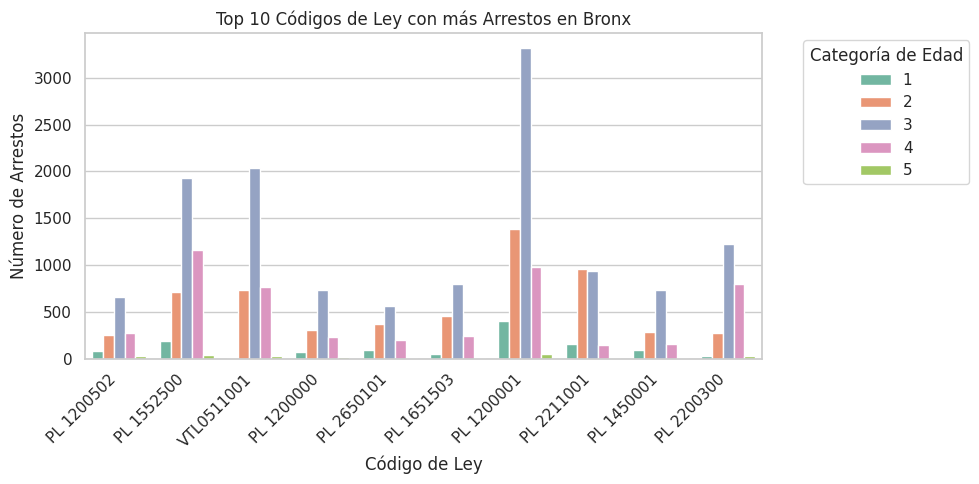

‚úÖ Gr√°fica guardada: /almacen/proyecto/graficas_proyecto/grafica_Bronx_arrestos.png


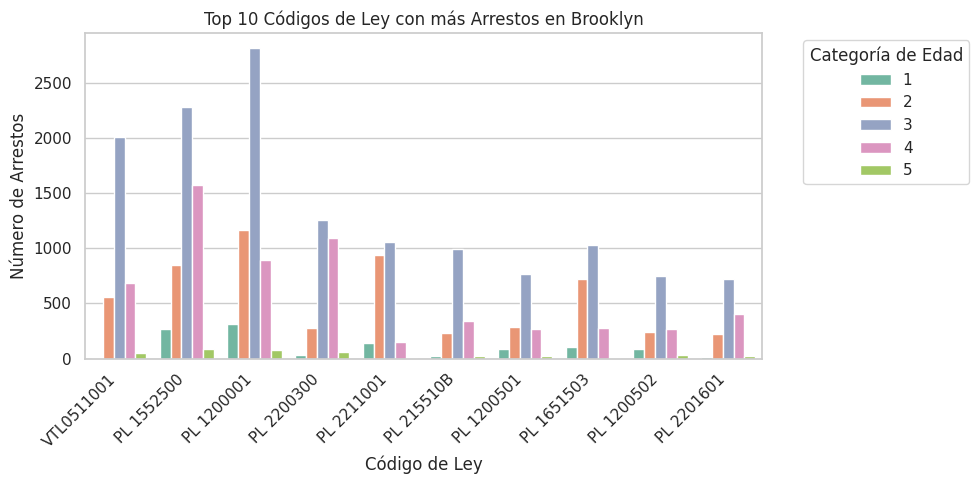

‚úÖ Gr√°fica guardada: /almacen/proyecto/graficas_proyecto/grafica_Brooklyn_arrestos.png


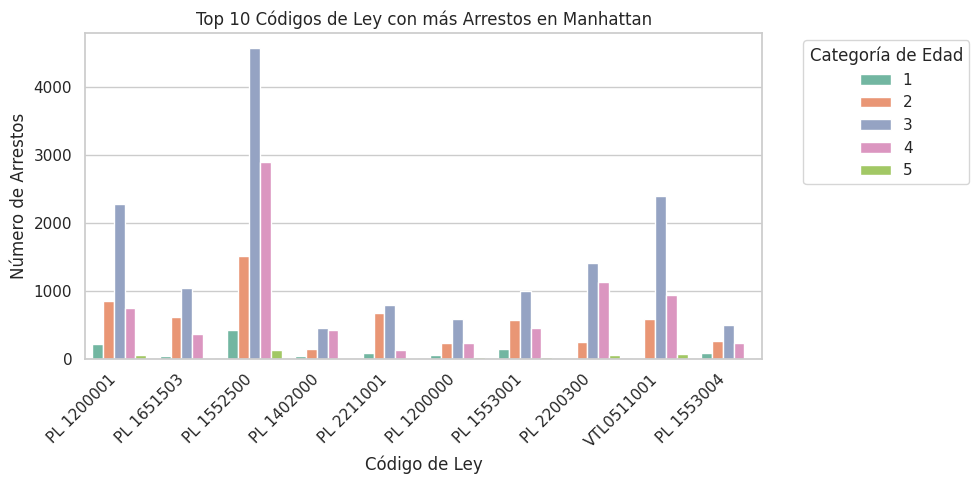

‚úÖ Gr√°fica guardada: /almacen/proyecto/graficas_proyecto/grafica_Manhattan_arrestos.png


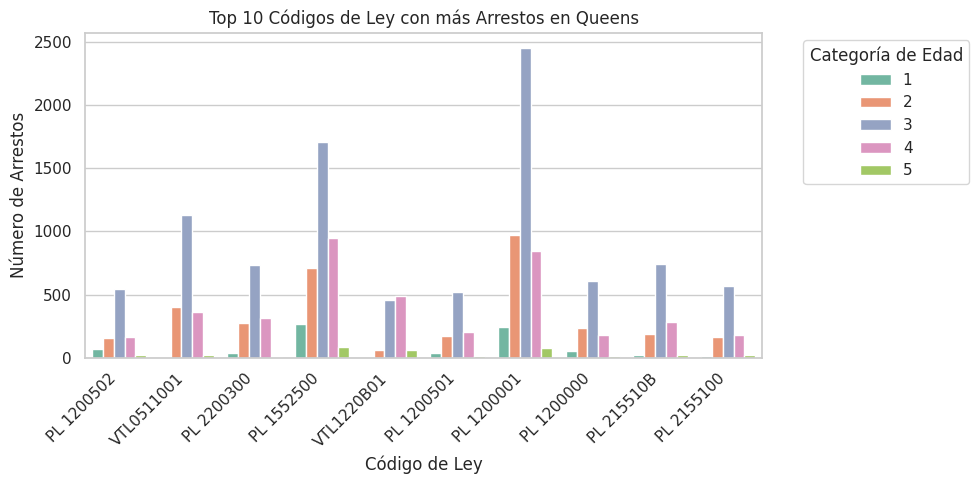

‚úÖ Gr√°fica guardada: /almacen/proyecto/graficas_proyecto/grafica_Queens_arrestos.png


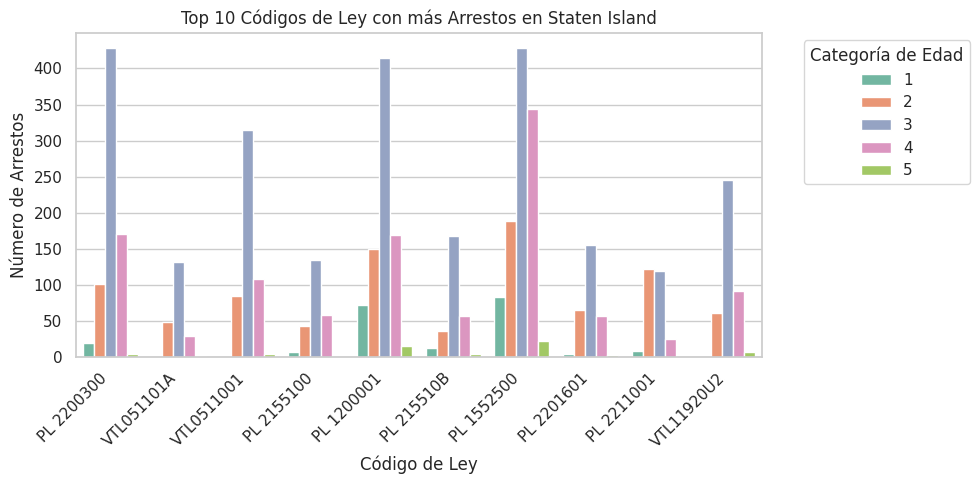

‚úÖ Gr√°fica guardada: /almacen/proyecto/graficas_proyecto/grafica_Staten_Island_arrestos.png

üéâ Todas las gr√°ficas fueron exportadas correctamente.


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Se define la ruta de guardado para exportar las gr√°ficas al cluster
ruta_guardado = '/almacen/proyecto/graficas_proyecto'
os.makedirs(ruta_guardado, exist_ok=True)

sns.set(style="whitegrid")

for boro, data in df_plot.groupby("Borough"):
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=data,
        x="LAW_CODE",
        y="TotalArrests",
        hue="AgeCategory",
        palette="Set2"
    )
    plt.title(f"Top {top_n} C√≥digos de Ley con m√°s Arrestos en {boro}")
    plt.xlabel("C√≥digo de Ley")
    plt.ylabel("N√∫mero de Arrestos")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Categor√≠a de Edad", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.show()
        # Guardar la gr√°fica en archivo PNG
    nombre_archivo = f"grafica_{boro.replace(' ', '_')}_arrestos.png"
    ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
    plt.savefig(ruta_completa, dpi=300)
    plt.close()  # Cierra la figura para liberar memoria
    
    print(f"‚úÖ Gr√°fica guardada: {ruta_completa}")

   

print("\nüéâ Todas las gr√°ficas fueron exportadas correctamente.")

## **Gr√°fica de n√∫mero de cr√≠menes por raza en cada distrito de NY**

In [24]:
from pyspark.sql import functions as F

# Agrupar por distrito (ARREST_BORO) y raza (PERP_RACE)
df_race_boro = (
    df01.groupBy("ARREST_BORO", "PERP_RACE")
        .agg(F.count("*").alias("TotalArrests"))
        .orderBy("ARREST_BORO")
)


In [25]:
# Converitmos el dataframe de pyspark a pandas para generar las visualizaciones
df_race_boro_pd = df_race_boro.toPandas()

In [26]:
#Se hace un mapeo de los distritos para las gr√°ficas
borough_names = {
    1: "Bronx",
    2: "Brooklyn",
    3: "Manhattan",
    4: "Queens",
    5: "Staten Island"
}

# Crear una columna temporal solo para los nombres legibles en la gr√°fica
df_race_boro_pd["BoroughName"] = df_race_boro_pd["ARREST_BORO"].map(borough_names)


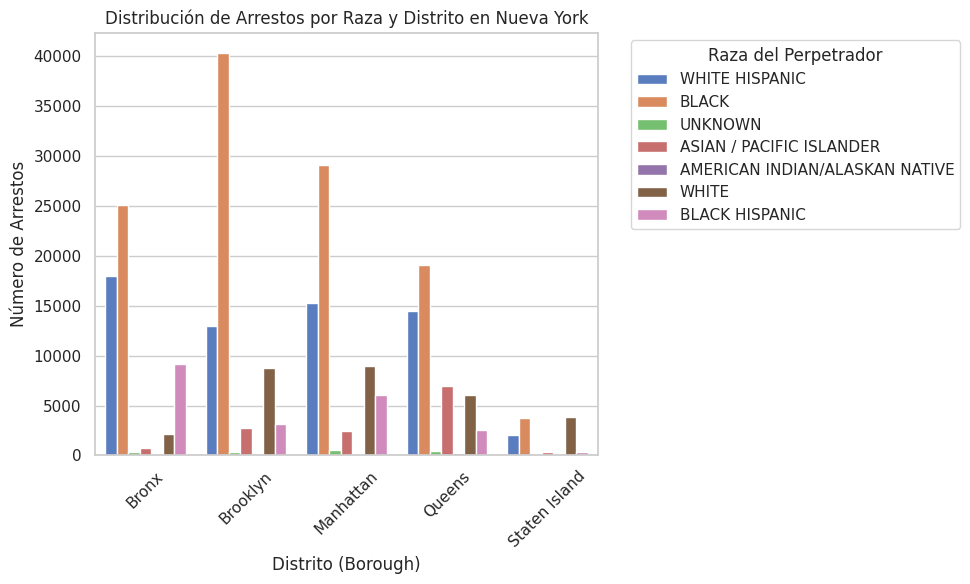

‚úÖ Gr√°fica guardada en: /almacen/proyecto/graficas_proyecto/grafica_arrestos_por_raza.png


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")

#Se genera la visualizaci√≥n
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_race_boro_pd,
    x="BoroughName",
    y="TotalArrests",
    hue="PERP_RACE"
)

plt.title("Distribuci√≥n de Arrestos por Raza y Distrito en Nueva York")
plt.xlabel("Distrito (Borough)")
plt.ylabel("N√∫mero de Arrestos")
plt.xticks(rotation=45)
plt.legend(title="Raza del Perpetrador", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

ruta_guardado = '/almacen/proyecto/graficas_proyecto/grafica_arrestos_por_raza.png'
plt.savefig(ruta_guardado, dpi=300)
plt.close()

print(f"‚úÖ Gr√°fica guardada en: {ruta_guardado}")


### **Gr√°fica de arrestos por distrito**

/tmp/ipykernel_288032/3288321814.py:94: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  nyc_boroughs_3857.boundary.plot(ax=ax, color="gray", linewidth=0.6, alpha=0.7, zorder=3)


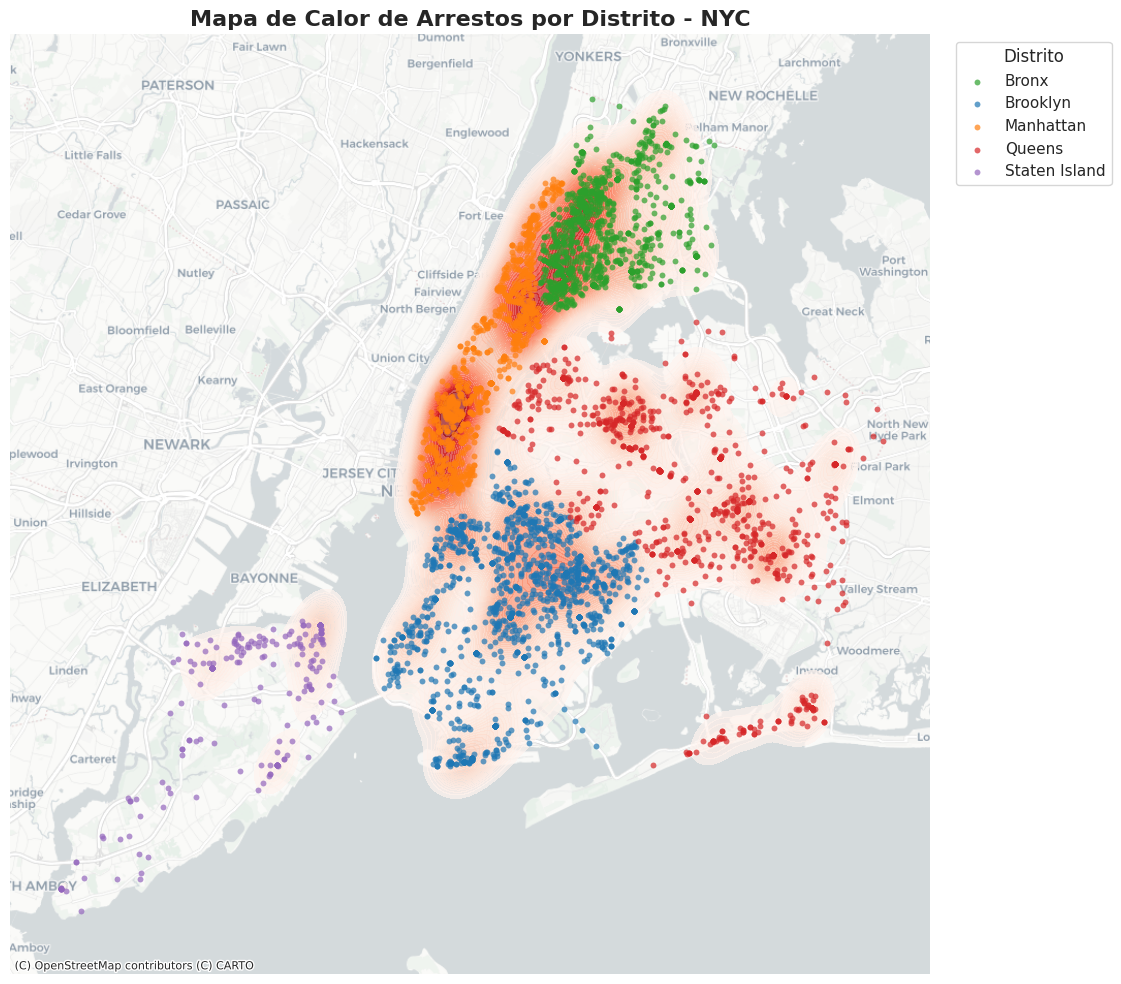

‚úÖ Mapa guardado en: /almacen/proyecto/graficas_proyecto/mapa_calor_arrestos.png


In [28]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import numpy as np
import os

# ------------------------
# Rutas y opciones
# ------------------------
shapefile_path = "/almacen/proyecto/archivos_mapas/geo_export_10e83475-8cb8-400e-9abf-4624791afdb9.shp"
ruta_salida = "/almacen/proyecto/graficas_proyecto"
os.makedirs(ruta_salida, exist_ok=True)
ruta_imagen = os.path.join(ruta_salida, "mapa_calor_arrestos.png")

# ------------------------
# 1) Cargar shapefile y poner en EPSG:4326 (si no lo est√°)
# ------------------------
nyc_boroughs = gpd.read_file(shapefile_path)
nyc_boroughs = nyc_boroughs.to_crs(epsg=4326)  # lat/lon

# ------------------------
# 2) Cargar y limpiar datos de arrestos desde PySpark -> pandas
# ------------------------
# Selecciona columnas necesarias y quita nulos
df_pd = df01.select("ARREST_BORO", "Latitude", "Longitude").dropna().toPandas()

# Eliminar filas con lat/lon no num√©ricas o infinitas
df_pd = df_pd[np.isfinite(df_pd['Latitude']) & np.isfinite(df_pd['Longitude'])]

# Filtrar fuera de los l√≠mites razonables de NYC (opcional, evita puntos err√≥neos)
df_pd = df_pd[(df_pd['Latitude'] > 40.4) & (df_pd['Latitude'] < 41.0) &
              (df_pd['Longitude'] > -74.3) & (df_pd['Longitude'] < -73.65)]

# Mapear nombres de borough (s√≥lo para colores/leyenda)
borough_names = {1:"Bronx",2:"Brooklyn",3:"Manhattan",4:"Queens",5:"Staten Island"}
df_pd["Borough"] = df_pd["ARREST_BORO"].map(borough_names)

# Si no hay datos, salir con aviso
if df_pd.shape[0] == 0:
    raise RuntimeError("No hay puntos v√°lidos tras limpiar lat/lon. Revisa el filtro.")

# ------------------------
# 3) Crear GeoDataFrame y proyectar a WebMercator (EPSG:3857) para el basemap
# ------------------------
gdf_arrestos = gpd.GeoDataFrame(
    df_pd,
    geometry=gpd.points_from_xy(df_pd.Longitude, df_pd.Latitude),
    crs="EPSG:4326"
)

# proyectar ambos GeoDataFrames a 3857 (metros) para contextily
gdf_arrestos_3857 = gdf_arrestos.to_crs(epsg=3857)
nyc_boroughs_3857  = nyc_boroughs.to_crs(epsg=3857)

# ------------------------
# 4) Preparar figura y ejes (un solo ax)
# ------------------------
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 10))

# ------------------------
# 5) Dibujar el KDE (mapa de calor) usando coordenadas proyectadas (x, y arrays)
# ------------------------
# seaborn.kdeplot acepta x,y como arrays; usamos arrays en metros (EPSG:3857)
x = gdf_arrestos_3857.geometry.x.values
y = gdf_arrestos_3857.geometry.y.values

# Para datasets muy grandes, puedes muestrear para el KDE (opcional)
kde_frac = 1.0  # poner 0.1 para muestrear 10%
if kde_frac < 1.0:
    idx = np.random.choice(len(x), int(len(x)*kde_frac), replace=False)
    x_kde, y_kde = x[idx], y[idx]
else:
    x_kde, y_kde = x, y

sns.kdeplot(
    x=x_kde,
    y=y_kde,
    fill=True,
    cmap="Reds",
    alpha=0.7,
    thresh=0.05,
    levels=50,
    bw_method="scott",  # o ajusta con bw_adjust si necesitas mayor/suave resoluci√≥n
    zorder=1,
    ax=ax
)

# ------------------------
# 6) Dibujar pol√≠gonos de boroughs (l√≠mites) en gris sutil
# ------------------------
nyc_boroughs_3857.boundary.plot(ax=ax, color="gray", linewidth=0.6, alpha=0.7, zorder=3)

# ------------------------
# 7) Dibujar puntos muestreados por borough, con colores distinguibles
# ------------------------
# Muestra peque√±a para no saturar el plot
sample_frac = 0.02
gdf_sample = gdf_arrestos_3857.sample(frac=sample_frac, random_state=42)

# Crear paleta por borough
unique_boros = gdf_sample['Borough'].unique()
palette = dict(zip(unique_boros, sns.color_palette("tab10", len(unique_boros))))

# Dibujar con ax.scatter para tener control del edgecolor
for boro, sub in gdf_sample.groupby("Borough"):
    ax.scatter(
        sub.geometry.x,
        sub.geometry.y,
        s=18,
        c=[palette[boro]],
        label=boro,
        alpha=0.7,
        edgecolors=None,
        linewidths=0,
        zorder=4
    )

# ------------------------
# 8) A√±adir basemap (contextily) ‚Äî requiere que los ejes est√©n en EPSG:3857
# ------------------------
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# ------------------------
# 9) Ajustes finales y guardar
# ------------------------
ax.set_axis_off()  # opcional: quita los ejes para estilo mapa
ax.set_title("Mapa de Calor de Arrestos por Distrito - NYC", fontsize=16, weight="bold")
ax.legend(title="Distrito", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(ruta_imagen, dpi=300, bbox_inches="tight")
plt.show()

print("‚úÖ Mapa guardado en:", ruta_imagen)